# UBC OCEAN Classifier - Fastai Training - 5 Random Tiles 1024px, .02 learning rate

* This notebook trains a fastai classifier on the generated dataset with the following parameters
    * Has 5 1024 pixel random crops for each image. 
    * TMA Scaling
    * Quality metric has improved percentage that processed. 
        * all thumbnail images are resized to 224 x 224 to use the vit pretrained model
        * arch = 'vit_base_patch16_224'
        * learning rate = .02
<br><br>
* Paths from here
    * Adjust learning rates
    * Change architectures
    * 512 model with 20x
    * 256 model with 80x
    * Other combos
    * Then avg blends, optimize weights
    


# Installs

In [1]:
# For IEEE style plotting
!pip install /kaggle/input/scienceplots-2-1-0/SciencePlots-2.1.0-py3-none-any.whl

Processing /kaggle/input/scienceplots-2-1-0/SciencePlots-2.1.0-py3-none-any.whl
SciencePlots is already installed with the same version as the provided wheel. Use --force-reinstall to force an installation of the wheel.


In [2]:
!ls /kaggle/input/pyvips-python-and-deb-package

!dpkg -i --force-depends /kaggle/input/pyvips-python-and-deb-package/linux_packages/archives/*.deb

!pip install pyvips -f /kaggle/input/pyvips-python-and-deb-package/python_packages/ --no-index
!pip list | grep pyvips


linux_packages	python_packages
(Reading database ... 115683 files and directories currently installed.)
Preparing to unpack .../autoconf_2.69-11.1_all.deb ...
Unpacking autoconf (2.69-11.1) over (2.69-11.1) ...
Preparing to unpack .../automake_1%3a1.16.1-4ubuntu6_all.deb ...
Unpacking automake (1:1.16.1-4ubuntu6) over (1:1.16.1-4ubuntu6) ...
Preparing to unpack .../autopoint_0.19.8.1-10build1_all.deb ...
Unpacking autopoint (0.19.8.1-10build1) over (0.19.8.1-10build1) ...
Preparing to unpack .../autotools-dev_20180224.1_all.deb ...
Unpacking autotools-dev (20180224.1) over (20180224.1) ...
Preparing to unpack .../bzip2-doc_1.0.8-2_all.deb ...
Unpacking bzip2-doc (1.0.8-2) over (1.0.8-2) ...
Preparing to unpack .../debhelper_12.10ubuntu1_all.deb ...
Unpacking debhelper (12.10ubuntu1) over (12.10ubuntu1) ...
Preparing to unpack .../dh-autoreconf_19_all.deb ...
Unpacking dh-autoreconf (19) over (19) ...
Preparing to unpack .../dh-strip-nondeterminism_1.7.0-1_all.deb ...
Unpacking dh-strip

# Imports

In [3]:
import fastai
from fastai.vision.all import *
fastai.__version__

'2.7.12'

In [4]:
import os
import gc
import shutil
from glob import glob
from os import path

import cv2
import numpy as np
import pandas as pd

import scienceplots
import matplotlib.pyplot as plt
plt.style.use(['science','no-latex'])
import seaborn as sns
import plotly.express as px

from tqdm.auto import tqdm

pd.set_option('display.float_format', '{:.2f}'.format)

import pyvips
pyvips.__version__

'2.2.2'

# Load Data

* There are four folders, train_images, train_thumbnails, test_images, test_thumbnails
    * There are 538 files in the train images folder, and 513 in the train_thumbnails folder
    * There is only one file in each of the test images/thumbnails folders.  It has the same label (41).
* There are three csv files, train, test, and sample_submission

Why do we have the thumbnails...to make training faster?

In [5]:
top_dir = '/kaggle/input/UBC-OCEAN'
new_train_dir = '/kaggle/input/ubc-dataset-1024px-5-random-tiles-tma-scaled'

train = pd.read_csv(top_dir + '/train.csv')
test = pd.read_csv(top_dir + '/test.csv')
ss = pd.read_csv(top_dir + '/sample_submission.csv')

## Train/Test Csv files EDA

In [6]:
print(f'Size of training data: {train.shape}')
display(train.head())
display(test.head())

Size of training data: (538, 5)


,image_id,label,image_width,image_height,is_tma
0,4,HGSC,23785,20008,False
1,66,LGSC,48871,48195,False
2,91,HGSC,3388,3388,True
3,281,LGSC,42309,15545,False
4,286,EC,37204,30020,False


,image_id,image_width,image_height
0,41,28469,16987


## Label Distribution

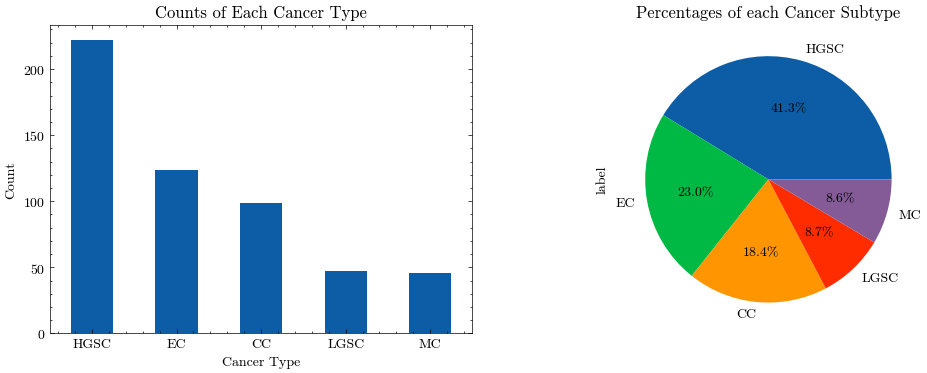

In [7]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
train['label'].value_counts().plot(kind='bar', xlabel='Cancer Type', ylabel='Count', rot=0)
plt.title('Counts of Each Cancer Type')
plt.subplot(1,2,2)
train['label'].value_counts().plot.pie(autopct='%1.1f%%', ylabel="label")
plt.title('Percentages of each Cancer Subtype');

## Add new path to images 
* With 512 pixel center tiles
* remove empty images better since implemented retries

In [ ]:
#train['image_path'] = train.image_id.apply(lambda n: f'{new_train_dir}/{str(n)}.png')

# train['image_path'] = train.image_id.apply(lambda n: f'{top_dir}/train_images/{str(n)}.png')
# test['image_path'] = test.image_id.apply(lambda n: f'{top_dir}/train_images/{str(n)}.png')
# train['thumb_path'] = train.image_id.apply(lambda n: f'{top_dir}/train_thumbnails/{str(n)}_thumbnail.png')
# test['thumb_path'] = test.image_id.apply(lambda n: f'{top_dir}/test_thumbnails/{str(n)}_thumbnail.png')
#train.head(3)

## Make a list of files and remove empty images

In [38]:
# make a list of all files in the dataset
train_files = glob(new_train_dir + '/**/*.png',recursive=True)
train_files = [file for file in train_files if '__results' not in file]  # will fix this on the next dataset

# for file in train_files:
#     if '__results' in file:
#         os.remove(file)
        
len(train_files)


2690

In [55]:
img_ids, labels = [],[]

for file in train_files:
    img_ids.append(file.split('/')[-1].split('_')[0])
    labels.append(file.split('/')[-2])

data = list(zip(img_ids,labels,train_files))
            
new_train = pd.DataFrame(data,columns=['img_id','label','img_path'])
new_train.head()

,img_id,label,img_path
0,11557,LGSC,/kaggle/input/ubc-dataset-1024px-5-random-tiles-tma-scaled/new_train/LGSC/11557_0.png
1,33976,LGSC,/kaggle/input/ubc-dataset-1024px-5-random-tiles-tma-scaled/new_train/LGSC/33976_2.png
2,37385,LGSC,/kaggle/input/ubc-dataset-1024px-5-random-tiles-tma-scaled/new_train/LGSC/37385_0.png
3,39258,LGSC,/kaggle/input/ubc-dataset-1024px-5-random-tiles-tma-scaled/new_train/LGSC/39258_0.png
4,39258,LGSC,/kaggle/input/ubc-dataset-1024px-5-random-tiles-tma-scaled/new_train/LGSC/39258_2.png


<Axes: xlabel='label'>

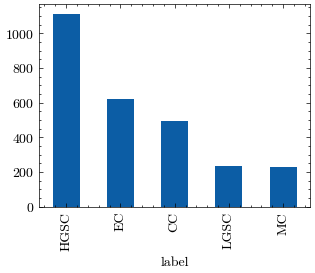

In [53]:
new_train.label.value_counts().plot(kind='bar')

In [12]:
# # in this set don't need to do this because they are all valid...need to update for next 
# idx = 0
# bad_idx = []
# tile_size = 1024

# for file in train_files:

#     im = pyvips.Image.new_from_file(file)
    
#     num_gt_0 = ((im > 0).avg() * im.width * im.height * im.bands) / 255
#     good_pixel_pct = 1 - num_gt_0/(3*tile_size**2)  # this is the percentage of not black pixels
    
#     avg_gt_0 = (im>0).avg()
    
#     #good_pixel_pct = (im > 0).avg()
#     #print(f'Image {img_id} avg > 0: {avg_gt_0}')
 
#     if avg_gt_0 == 0.0:
#         print('bad file')
        
#         #os.remove(file)  # cant do this in a read only filesystem
        
#     idx +=1


filename: /kaggle/input/ubc-dataset-1024px-5-random-tiles-tma-scaled/new_train/LGSC/11557_0.png
filename: /kaggle/input/ubc-dataset-1024px-5-random-tiles-tma-scaled/new_train/LGSC/33976_2.png
filename: /kaggle/input/ubc-dataset-1024px-5-random-tiles-tma-scaled/new_train/LGSC/37385_0.png
filename: /kaggle/input/ubc-dataset-1024px-5-random-tiles-tma-scaled/new_train/LGSC/39258_0.png
filename: /kaggle/input/ubc-dataset-1024px-5-random-tiles-tma-scaled/new_train/LGSC/39258_2.png
filename: /kaggle/input/ubc-dataset-1024px-5-random-tiles-tma-scaled/new_train/LGSC/31793_3.png
filename: /kaggle/input/ubc-dataset-1024px-5-random-tiles-tma-scaled/new_train/LGSC/36583_4.png
filename: /kaggle/input/ubc-dataset-1024px-5-random-tiles-tma-scaled/new_train/LGSC/23796_4.png
filename: /kaggle/input/ubc-dataset-1024px-5-random-tiles-tma-scaled/new_train/LGSC/49872_1.png
filename: /kaggle/input/ubc-dataset-1024px-5-random-tiles-tma-scaled/new_train/LGSC/26862_3.png
filename: /kaggle/input/ubc-dataset-1024

# Model
* The goal is to start with Fastai and the thumbnail images
    * Then use the larger images, deal with tiling, etc.
    * First need to create a subfolder structure which loads the correct thumbnails into the correct folders

## Fastai Model Setup

In [56]:
from fastai.vision.all import *
import timm

In [57]:
from sklearn.model_selection import StratifiedKFold
num_folds = 4
skf = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=12)

In [ ]:
%%time
preds = []
acc_val = []
epochs = 5
lr = .02
arch = 'vit_small_patch16_224' # 'vit_base_patch16_224'
#arch = 'swin_base_patch4_window7_224_in22k'
#arch = 'vit_base_patch16_224'
#arch = 'convnext_tiny_in22k'

fold = 1

for train_index,val_index in skf.split(new_train.index,new_train['label']):
    
    # get set validation true/false column
    v = []
    for i in range(new_train.shape[0]):
        if i in val_index:
            v.append(True)
        else:
            v.append(False)

    new_train['validation'] = v

    # create a dataloader
#     dls = ImageDataLoaders.from_df(df, path, valid_col='validation',fn_col='image', label_col='label',
#                                    item_tfms=Resize(280), 
#                                    batch_tfms=aug_transforms(size=224, flip_vert=True))#.split_by_idxs(train_idx=train_index, valid_idx=val_index)
    
    dls = ImageDataLoaders.from_df(new_train,path='/',valid_col='validation',fn_col='img_path', label_col='label', seed=12,
                                   #item_tfms=Resize(280, method='squish'),
                                   item_tfms=Resize(224, method=ResizeMethod.Pad, pad_mode=PadMode.Zeros),
                                   #batch_tfms=aug_transforms(size=224, max_rotate=180)
                                   )
                                                                    
#     dls = DataBlock(
#                     blocks=(ImageBlock, CategoryBlock),  #input is an image, output is a category
#                     get_items = get_image_files,   #returns a list of all images files path
#                     splitter=RandomSplitter(valid_pct=0.2, seed=12),  # set size of validation set (randomly)
#                     get_y = parent_label,   # how do we know the correct label?  This function returns the parent folder of the path
#                     item_tfms=[Resize(224, method=ResizeMethod.Pad, pad_mode=PadMode.Zeros)]  # most architectures need all images the same size
#                     ).dataloaders(path)   #dataloaders are what pytorch uses to feed the training algo.
    
    
    learn = vision_learner(dls, arch, metrics=accuracy, path='.').to_fp16()  # vision transformer
    learn.fine_tune(epochs, lr)
    loss,acc = learn.validate()
    acc_val.append([loss,acc])
    
    #tst_dl = dls.test_dl(tst_files)
    # We will use test time augmentation...
    #tta_preds,_ = learn.tta(dl=tst_dl)
    
    #preds.append(tta_preds)
    # get max probability per row....later I think
    # pred_idxs = tta_preds.argmax(dim=1)
    
    fold +=1
    
    gc.collect()
    
# with arch = 'vit_base_patch16_224', lb = .25
# with 'vit_small_patch16_224'

/opt/conda/lib/python3.10/site-packages/torch/amp/autocast_mode.py:204: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/opt/conda/lib/python3.10/site-packages/torch/cuda/amp/grad_scaler.py:120: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn("torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.")


epoch,train_loss,valid_loss,accuracy,time
0,2.042506,1.795957,0.515602,07:23


epoch,train_loss,valid_loss,accuracy,time
0,1.241101,1.119190,0.601783,09:32
1,1.136590,1.258154,0.515602,09:29
2,0.906563,1.088015,0.634472,09:45
3,0.630838,0.933693,0.684993,09:30
4,0.414112,0.943668,0.692422,09:37


/opt/conda/lib/python3.10/site-packages/torch/amp/autocast_mode.py:204: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/opt/conda/lib/python3.10/site-packages/torch/cuda/amp/grad_scaler.py:120: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn("torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.")


epoch,train_loss,valid_loss,accuracy,time
0,2.012668,1.452019,0.512630,07:31


epoch,train_loss,valid_loss,accuracy,time
0,1.244953,1.243468,0.570579,09:40
1,1.084527,1.373860,0.576523,09:55
2,0.898378,1.210527,0.670134,09:35
3,0.622006,1.116314,0.698366,09:38
4,0.403714,1.036430,0.710253,09:26


/opt/conda/lib/python3.10/site-packages/torch/amp/autocast_mode.py:204: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/opt/conda/lib/python3.10/site-packages/torch/cuda/amp/grad_scaler.py:120: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn("torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.")


epoch,train_loss,valid_loss,accuracy,time
0,2.001380,1.496509,0.525298,07:24


epoch,train_loss,valid_loss,accuracy,time
0,1.221813,1.222496,0.546131,09:53
1,1.109964,1.535675,0.529762,09:35


In [ ]:
# path = Path(new_train_dir)
# path

In [ ]:
# how I did it with the snakes classifier

# dls = DataBlock(
#     blocks=(ImageBlock, CategoryBlock),  #input is an image, output is a category
#     get_items = get_image_files,   #returns a list of all images files path
#     splitter=RandomSplitter(valid_pct=0.2, seed=12),  # set size of validation set (randomly)
#     get_y = parent_label,   # how do we know the correct label?  This function returns the parent folder of the path
#     item_tfms=[Resize(224, method=ResizeMethod.Pad, pad_mode=PadMode.Zeros)]  # most architectures need all images the same size
# ).dataloaders(path)   #dataloaders are what pytorch uses to feed the training algo.

dls.show_batch(max_n=9) # shows the input (picture) and the label


In [ ]:
# learn = vision_learner(dls,resnet18,metrics=error_rate)
# learn.fine_tune(3)

In [ ]:
# #learn.lr_find(suggest_funcs=(valley, slide))
# loss,acc = learn.validate()
learn.dls.vocab

In [ ]:
acc_val = np.array(acc_val)
acc_val

In [ ]:
print(f'Loss is {loss:.3f}, accuracy is {acc:.3f}')
# print(f'Mean is: {np.mean(acc_val[:,1]):.5f}, std is: {np.std(acc_val[:,1]):.5f}')

# mean .53883 with no scaling
# Mean is .44932 next run (.05 lr)...This verifies that randomness is greater for scores than scaling, but do another
# still lr =.05, mean is .48695
# again, .47521 (this just doesn't seem like a great optimized solution)
# try .01, .50498, looks like this set has worse images

In [ ]:
# save so I can infer in the next notebook.  downloaded this file 11/14/23 3:38pm
learn.export(fname='5_rndtiles_1024_tma_sc_5_epochs_02_lr.pkl')